In [1]:
!pip install mlflow

In [2]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import sys

# Añadimos la carpeta 'drive' al path
ruta_carpeta_drive = os.path.abspath('../drive') #.. era para salirse de la carpeta actual y entrar en la de drive
if ruta_carpeta_drive not in sys.path:
    sys.path.insert(0, ruta_carpeta_drive)

import drive

# Descargamos los datos en formato parquet de Google Drive
# guardar localmente
drive.descargar_archivos_concretos('minEstratificado.parquet', '../drive')
#hay que pasarle la ruta a la carpeta drive desde donde lo estamos ejecutando
# y el nombre del archivo que hemos puesto en el archivos_info.txt (MLP_runs.db en nuestro ejemplo, en vez de datosEntrenamiento.parquet...)
# leer para utilizar esto ya en el modelo
datos1 = pd.read_parquet('datos/minEstratificado.parquet') # 
datos1

Archivo minEstratificado.parquet guardado en: ./datos/minEstratificado.parquet


,name,EventStartTime,SalesStartTIme,SalesEndTime,min_price,nameArtist,VenueName,VenueCity,VenueState,num_links,...,Singer-Songwriter,Soul,Urban,World,tiene_wiki,tiene_youtube,dias_Venta,dias_desdeFinVenta,num_noches,fold
0,"30 Aniversario de Sôber, con Savia y Skizoo",2024-03-08 20:00:00+00:00,2023-12-14 11:00:00+00:00,2024-03-08 20:00:00+00:00,28.0,Sober,Live Las Ventas,Madrid,Madrid,1,...,0,0,0,0,0,0,85,0,1,0
1,"30 Aniversario de Sôber, con Savia y Skizoo | ...",2024-03-08 20:00:00+00:00,2023-12-14 11:00:00+00:00,2024-03-08 20:00:00+00:00,50.0,Sober,Live Las Ventas,Madrid,Madrid,1,...,0,0,0,0,0,0,85,0,1,0
2,AC/DC - Power Up Tour,2024-05-25 19:00:00+00:00,2024-01-31 11:00:00+00:00,2024-05-25 19:00:00+00:00,105.0,AC/DC,Estadio La Cartuja de Sevilla,Sevilla,Seville,10,...,0,0,0,0,1,1,115,0,1,0
3,AC/DC - Power Up Tour,2024-05-29 19:30:00+00:00,2024-02-16 09:00:00+00:00,2024-05-29 19:30:00+00:00,105.0,AC/DC,Estadio La Cartuja de Sevilla,Sevilla,Seville,10,...,0,0,0,0,1,1,103,0,1,0
4,AC/DC - Power Up Tour,2024-12-14 20:00:00+00:00,2024-03-01 11:00:00+00:00,2024-12-14 20:00:00+00:00,105.0,AC/DC,Estadio La Cartuja de Sevilla,Sevilla,Seville,10,...,0,0,0,0,1,1,288,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,Yung Sarria,2024-03-30 20:00:00+00:00,2023-10-06 13:00:00+00:00,2024-03-30 20:00:00+00:00,12.0,Yung Sarria,Sala Shoko,Madrid,Madrid,0,...,0,0,1,0,0,0,176,0,1,3
490,ZENOBIA + DEBLER,2024-06-01 19:30:00+00:00,2024-02-20 09:00:00+00:00,2024-06-01 19:30:00+00:00,22.0,Zenobia,Sala Shoko,Madrid,Madrid,1,...,0,0,0,0,0,0,102,0,1,3
491,gREAT sTRAITS,2024-10-19 19:30:00+00:00,2024-01-02 11:00:00+00:00,2024-10-19 19:30:00+00:00,35.0,gREAT sTRAITS,Sala Razzmatazz 1,Barcelona,Barcelona,0,...,0,0,0,0,0,0,291,0,1,3
492,gREAT sTRAITS,2024-09-13 19:30:00+00:00,2023-12-22 09:00:00+00:00,2024-09-13 19:30:00+00:00,38.0,gREAT sTRAITS,La Riviera,Madrid,Madrid,0,...,0,0,0,0,0,0,266,0,1,3


In [4]:
 # Eliminamos las categoricas
columnas=['name','EventStartTime', 'SalesStartTIme', 'SalesEndTime', 'nameArtist', 'VenueName',
          'VenueCity', 'VenueState','Generos_combinados']

datos=datos1.drop(columnas, axis=1)

In [5]:
RANDOM_STATE = 83 #fijamos la semilla

# y es la variable objetivo
X = datos.drop(columns=['min_price', 'fold'],axis=1)
y = datos['min_price']
folds = datos['fold'].unique()

In [7]:

def cargar_modelo_mlflow(mlp, experimento, run_name, results, time):
    
    # Convertir resultados a DataFrame
    results_df = pd.DataFrame(results)
    results_df.to_csv("results.csv", index=False)

    # Iniciar un nuevo run de MLflow
    with mlflow.start_run(run_name=run_name):

        # Configurar el experimento de MLflow
        mlflow.set_experiment(experimento)
        
        mlflow.log_param("random_state", RANDOM_STATE)
        mlflow.log_params(mlp.get_params())
        mlflow.log_metric("execution_time", time)
        
        mlflow.sklearn.log_model(mlp, "model")
        
        # Registrar el archivo CSV en MLflow
        mlflow.log_artifact("results.csv", "results")

    mlflow.end_run()


In [6]:
# Sets the sqlite db as the MLFLOW_TRACKING_URI 
import os
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///mlruns.db'

# WARNING: TO SEE THE LOCAL SERVER YOU HAVE TO CHOOSE THE CORRECT BACKEND STORE AS FOLLOWS:
# mlflow ui --port 8080 --backend-store-uri sqlite:///mlruns.db

mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

In [8]:
def crear_tabla_resultados(resultados):
    # Eliminar la clave 'estimator' del diccionario resultados
    resultados = {key: val for key, val in resultados.items() if key != 'estimator'}

    # Crear un DataFrame con los resultados de validación cruzada
    df = pd.DataFrame(resultados)

    # Calcular promedios
    promedio = df.mean()

    # Crear DataFrame sin la fila de promedio
    df_sin_promedio = pd.DataFrame({
        'Test Fold': range(0, len(resultados['test_mse'])),
        'MAPE Train': -resultados['train_mape'],  # Convertir MAPE a positivo
        'RMSE Train': resultados['train_rmse'],
        'MSE Train': -resultados['train_mse'],  # Convertir MSE a positivo
        'MAPE Val': -resultados['test_mape'],  # Convertir MAPE a positivo
        'RMSE Val': resultados['test_rmse'],
        'MSE Val': -resultados['test_mse'],  # Convertir MSE a positivo
    })

    # Crear DataFrame con la fila de promedio
    df_promedio = pd.DataFrame({
        'Test Fold': ['Promedio'],
        'MAPE Train': -promedio['train_mape'],  # Convertir MAPE a positivo
        'RMSE Train': promedio['train_rmse'],
        'MSE Train': -promedio['train_mse'],  # Convertir MSE a positivo
        'MAPE Val': -promedio['test_mape'],  # Convertir MAPE a positivo
        'RMSE Val': promedio['test_rmse'],
        'MSE Val': -promedio['test_mse'],  # Convertir MSE a positivo
    }, index=[len(resultados['test_mse'])])  # Usamos el índice len(resultados['test_mse']) para colocar la fila de promedio al final

    # Concatenar los DataFrames
    df_final = pd.concat([df_sin_promedio, df_promedio])

    return df_final


MODELO BASE

In [9]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import PredefinedSplit, cross_validate
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, make_scorer
import numpy as np
import time

# Definir la semilla aleatoria
RANDOM_STATE = 83
# Crear el experimento "Modelos Max Price" si no existe
experiment_name = "Modelos Min Price"
mlflow.set_experiment(experiment_name)
# Definir el array test_fold a partir de la columna 'fold'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Definir las métricas a utilizar
scoring = {
    'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'rmse': make_scorer(mean_squared_error, squared=False),
    'mse': 'neg_mean_squared_error',
    'mae': make_scorer(mean_absolute_error, greater_is_better=False)
}

# Inicializar el modelo de árbol de decisión
tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

# Tiempo de inicio de la ejecución
start_time = time.time()

# Obtener los scores de validación cruzada para todas las métricas
scores = cross_validate(tree, X, y, cv=ps, scoring=scoring, return_train_score=True, return_estimator=True)

# Tiempo de finalización de la ejecución
end_time = time.time()

# Calcular el tiempo de ejecución en segundos
execution_time = end_time - start_time

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Crear la tabla de resultados
resultados = crear_tabla_resultados(scores)

# Definir los argumentos para la función cargar_modelo_mlflow
run_name = "Modelo Base Decision Tree"
mlp = tree  # Tu modelo

# Llamar a la función cargar_modelo_mlflow
cargar_modelo_mlflow(mlp, experiment_name, run_name, resultados, execution_time)



2024/06/10 16:22:27 INFO mlflow.tracking.fluent: Experiment with name 'Modelos Min Price' does not exist. Creating a new experiment.


Tiempo de ejecución: 0.021673917770385742 segundos


Modelo con parámetros y con búsqueda random search

In [10]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_validate, PredefinedSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, make_scorer
import numpy as np
import time

# Inicializar el modelo de árbol de decisión
tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

# Definir el espacio de búsqueda de hiperparámetros
params = {
    'max_depth': [None, 20, 25, 30, 45, 55],
    'min_samples_split': [3, 5, 15, 20, 30],
    'min_samples_leaf': [1, 3, 5, 6, 8]
}

# Crear el generador de índices personalizado para usar con RandomizedSearchCV
cv = PredefinedSplit(test_fold=datos['fold'])

# Tiempo de inicio de la búsqueda aleatoria
start_time_random = time.time()

# Realizar la búsqueda aleatoria de hiperparámetros
randomSearch = RandomizedSearchCV(estimator=tree, param_distributions=params, n_iter=100, cv=cv,
                                  n_jobs=-1, scoring='neg_mean_squared_error', random_state=RANDOM_STATE)
randomSearch.fit(X, y)

# Tiempo de finalización de la búsqueda aleatoria
end_time_random = time.time()
execution_time_random = end_time_random - start_time_random

print("Tiempo de ejecución RandomizedSearchCV:", execution_time_random, "segundos")
print('Mejores parámetros RandomizedSearchCV: ', randomSearch.best_params_)
print('Mejor puntuación (MSE) RandomizedSearchCV: ', -randomSearch.best_score_)

# Obtener el mejor modelo
best_model_random = randomSearch.best_estimator_

# Definir las métricas a utilizar
scoring = {
    'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'rmse': make_scorer(mean_squared_error, squared=False),
    'mse': 'neg_mean_squared_error'
}

# Convertir el generador de índices en una lista
cv_splits = list(cv.split())

# Realizar la validación cruzada con el mejor modelo
start_time_cv = time.time()
scores = cross_validate(best_model_random, X, y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=True)
end_time_cv = time.time()

# Calcular el tiempo de ejecución de la validación cruzada en segundos
execution_time_cv = end_time_cv - start_time_cv

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución de la validación cruzada:", execution_time_cv, "segundos")

# Crear la tabla de resultados
resultados = crear_tabla_resultados(scores)

run_name = "Modelo RandomSearch Decision Tree"
mlp = tree  # Tu modelo

# Llamar a la función cargar_modelo_mlflow
cargar_modelo_mlflow(mlp, experiment_name, run_name, resultados, execution_time_cv)



Tiempo de ejecución RandomizedSearchCV: 3.0500781536102295 segundos
Mejores parámetros RandomizedSearchCV:  {'min_samples_split': 30, 'min_samples_leaf': 5, 'max_depth': 45}
Mejor puntuación (MSE) RandomizedSearchCV:  212.88241600508894
Tiempo de ejecución de la validación cruzada: 0.01450204849243164 segundos


In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px

# Define el modelo con los parámetros encontrados mediante GridSearchCV
best_model_random = DecisionTreeRegressor(min_samples_split=30, min_samples_leaf=5,max_depth=45,random_state=RANDOM_STATE)

# Entrena el modelo con tus datos
best_model_random.fit(X, y)

# Realiza predicciones con el modelo entrenado
predicciones = best_model_random.predict(X)

# Crea un DataFrame con los precios reales, predichos y el nombre del concierto
df = pd.DataFrame({'Nombre del Concierto': datos1['name'], 'Precio Real': y, 'Precio Predicho': predicciones})

# Crea un scatter plot interactivo con Plotly
fig = px.scatter(df, x='Precio Real', y='Precio Predicho', color='Nombre del Concierto',
                 title='Comparación de Precios Reales vs Precios Predichos (Random Forest)',
                 labels={'Precio Real': 'Precio Real', 'Precio Predicho': 'Precio Predicho'})

# Agrega una línea diagonal que representa la igualdad entre los precios reales y predichos
fig.add_shape(type='line',
              x0=df['Precio Real'].min(), y0=df['Precio Real'].min(),
              x1=df['Precio Real'].max(), y1=df['Precio Real'].max(),
              line=dict(color='red', width=2, dash='dash'))

# Mostrar el scatter plot interactivo
fig.show()


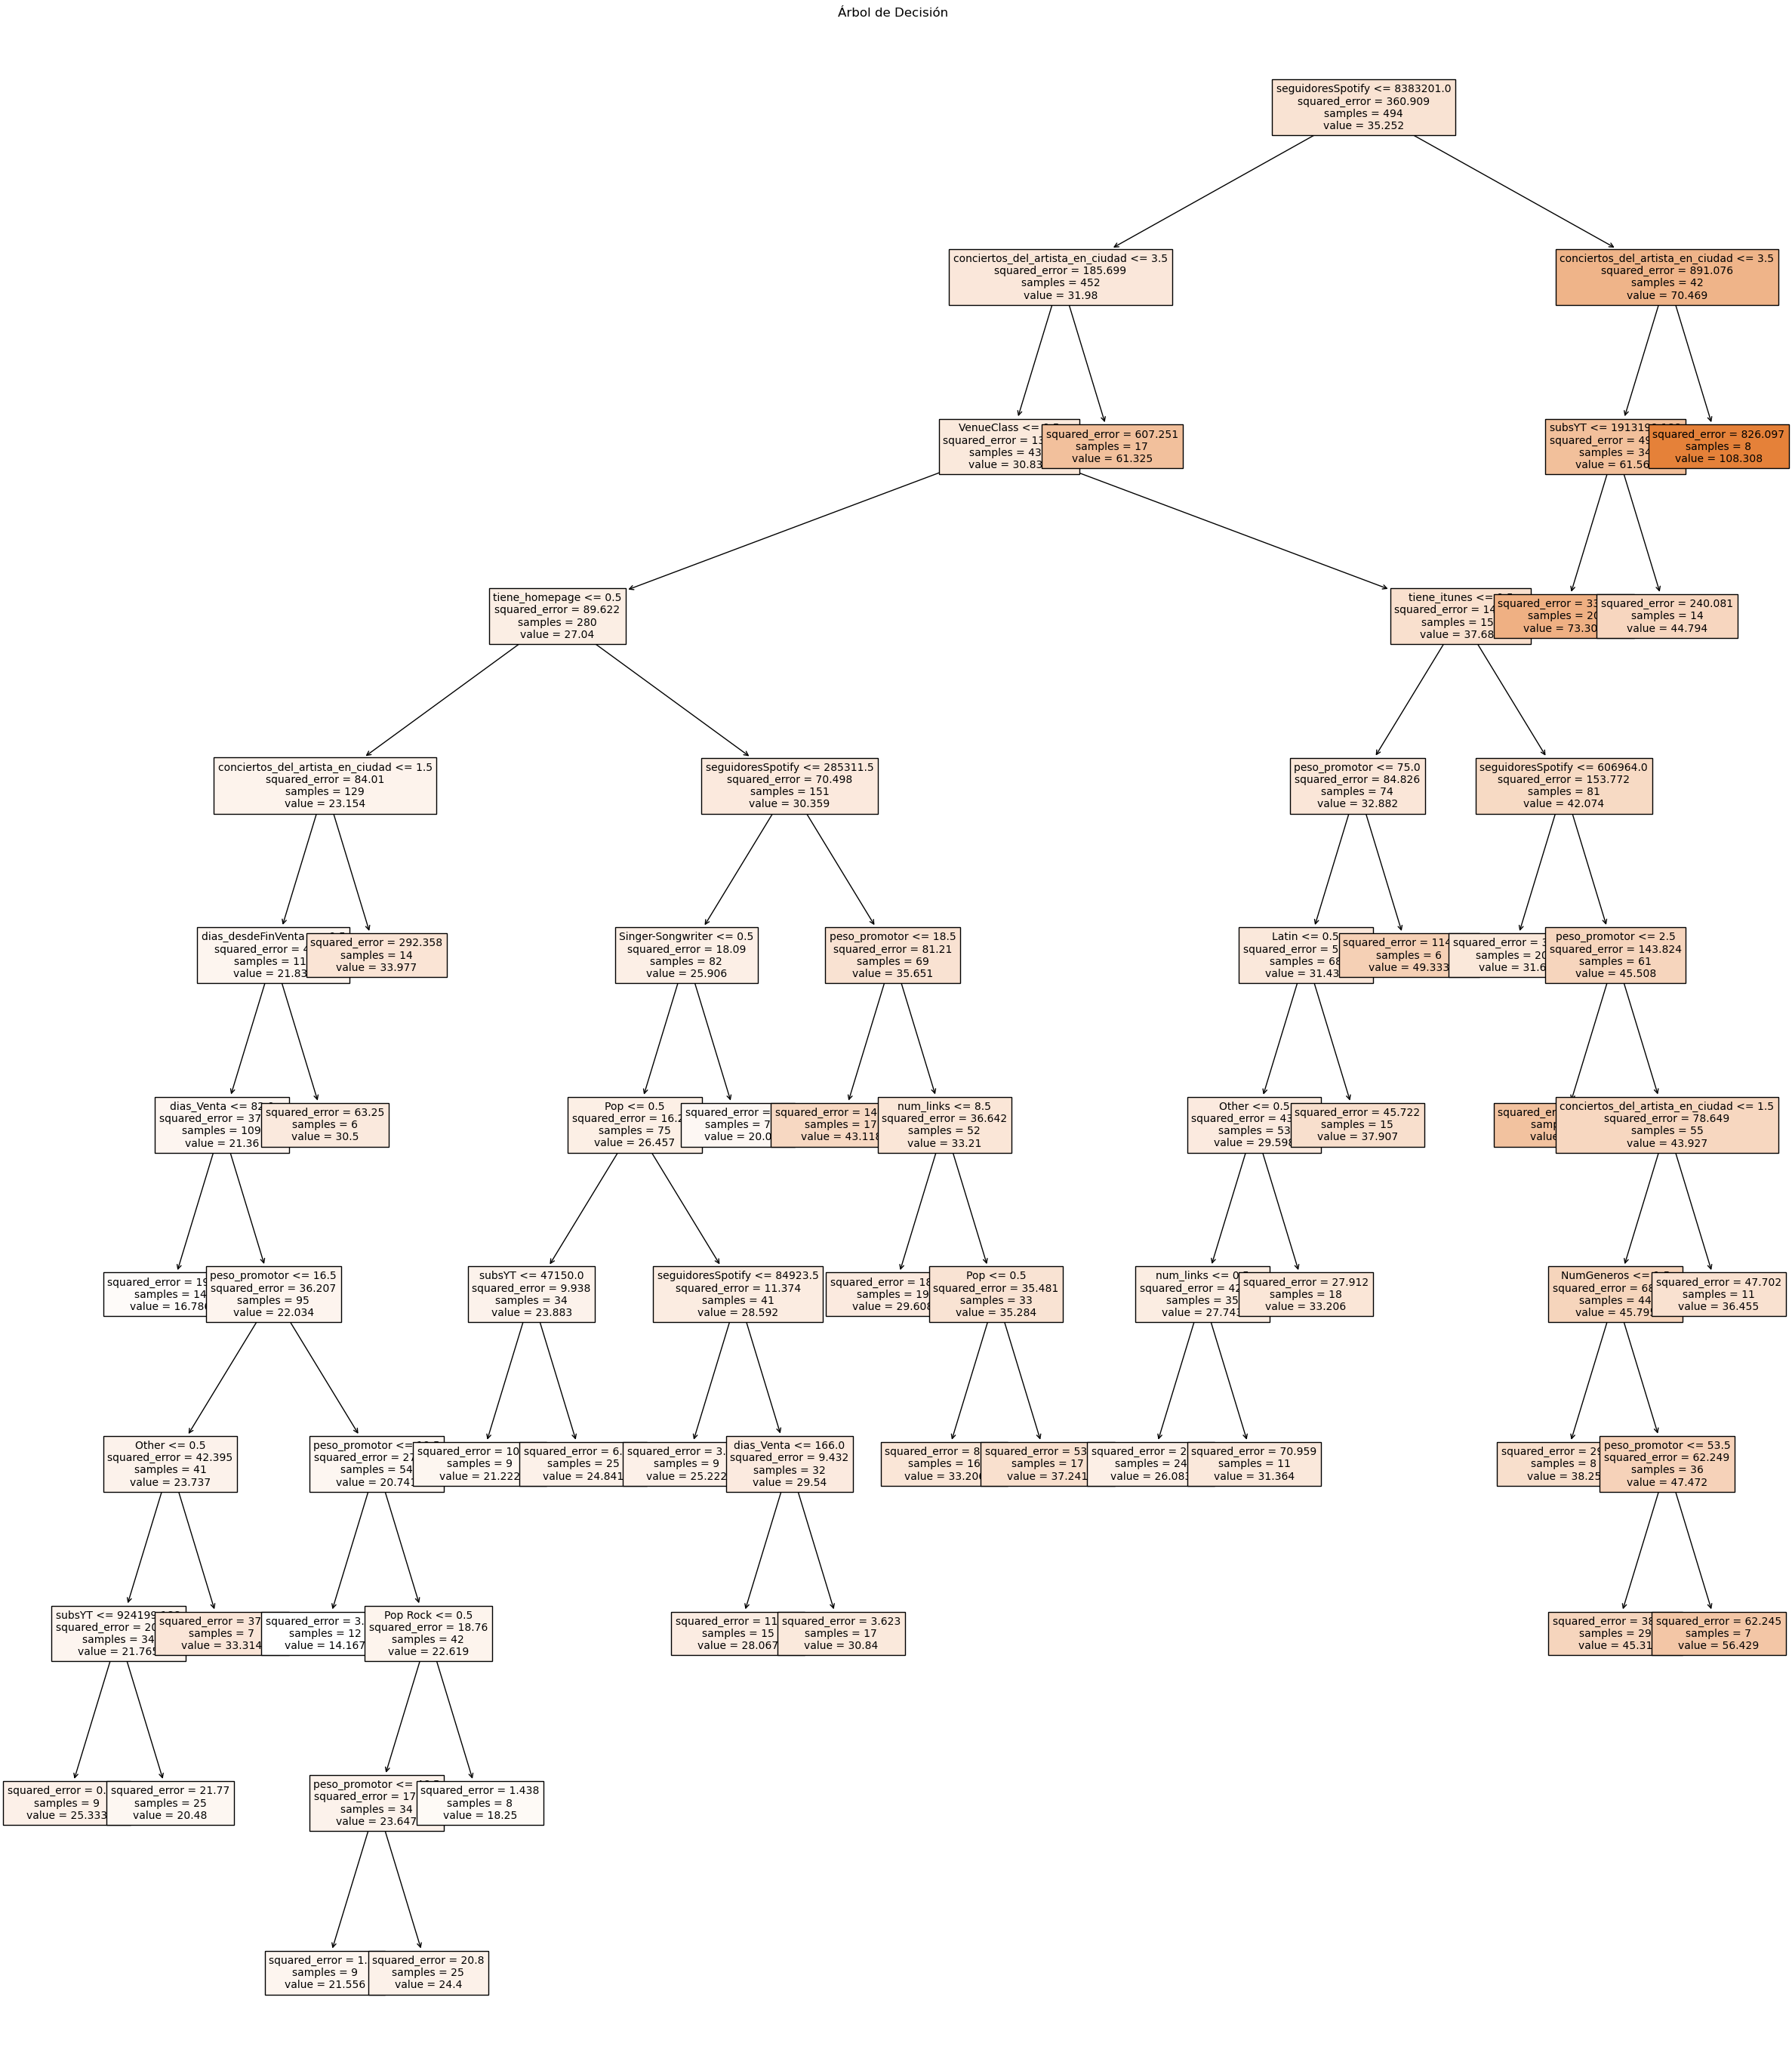

In [13]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualizar el árbol de decisión
plt.figure(figsize=(30, 35))
plot_tree(best_model_random, filled=True, feature_names=X.columns.tolist(), fontsize=10)
plt.title("Árbol de Decisión")
plt.show()



Características más importantes del modelo:
seguidoresSpotify: 0.4826228256949157
conciertos_del_artista_en_ciudad: 0.24284931475445068
VenueClass: 0.08590172732704901
subsYT: 0.05269587471300113
peso_promotor: 0.04594983187582435
tiene_homepage: 0.027435958727817202
tiene_itunes: 0.02481961858485232
Other: 0.008576983827134616
Latin: 0.006131023035325641
num_links: 0.004548473753252669


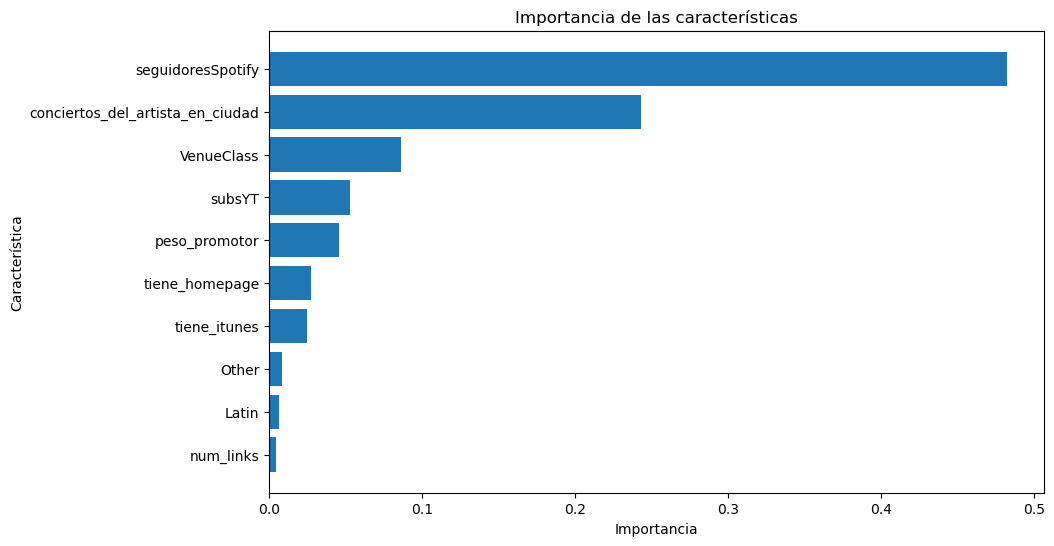

In [14]:
# Importancia de las características
feature_importance_random = best_model_random.feature_importances_
top_indices_random = np.argsort(feature_importance_random)[::-1][:10]

print("\nCaracterísticas más importantes del modelo:")
for i in top_indices_random:
    print(f"{X.columns[i]}: {feature_importance_random[i]}")

# Crear un DataFrame para las importancias de las características
df_feature_importance = pd.DataFrame({
    'Característica': X.columns[top_indices_random],
    'Importancia': feature_importance_random[top_indices_random]
})

# Visualizar las características más importantes
plt.figure(figsize=(10, 6))
plt.barh(df_feature_importance['Característica'], df_feature_importance['Importancia'])
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las características')
plt.gca().invert_yaxis()
plt.show()

Búsqueda con Grid Search

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import PredefinedSplit  # Importar PredefinedSplit
import time

# Define tu semilla aleatoria
RANDOM_STATE = 83

print('MODELO PARÁMETROS GRID SEARCH')

tree = DecisionTreeRegressor(random_state=RANDOM_STATE)

params = {
    'max_depth': [None, 20, 30, 40, 50,55],
    'min_samples_split': [3, 5, 10, 15, 30],
    'min_samples_leaf': [1, 3, 4, 6, 8]
}

# Crear el generador de índices personalizado para usar con GridSearchCV
cv = [(datos.index[datos['fold'] != fold].tolist(), datos.index[datos['fold'] == fold].tolist()) for fold in datos['fold'].unique()]

start_time_grid = time.time()
gridSearch = GridSearchCV(estimator=tree, param_grid=params, cv=cv,
                          n_jobs=-1, scoring='neg_mean_squared_error')
gridSearch.fit(X, y)
end_time_grid = time.time()
execution_time_grid = end_time_grid - start_time_grid

print("Tiempo de ejecución GridSearchCV:", execution_time_grid, "segundos")
print('Mejores parámetros GridSearchCV: ', gridSearch.best_params_)
print('Mejor puntuación (MSE) GridSearchCV: ', -gridSearch.best_score_)

best_model_grid = gridSearch.best_estimator_

# Realizar la validación cruzada con el mejor modelo y PredefinedSplit
test_fold = datos['fold'].values
ps = PredefinedSplit(test_fold=test_fold)

# Realizar la validación cruzada con el mejor modelo
scores = cross_validate(best_model_grid, X, y, cv=ps, scoring=scoring, return_train_score=True, return_estimator=True)

# Crear la tabla de resultados utilizando la función crear_tabla_resultados
resultados = crear_tabla_resultados(scores)
# Definir los argumentos para la función cargar_modelo_mlflow
run_name = "MODELO PARÁMETROS GRID SEARCH Decision Tree"
mlp = tree  # Tu modelo

# Llamar a la función cargar_modelo_mlflow
cargar_modelo_mlflow(mlp, experiment_name, run_name, resultados, execution_time)



MODELO PARÁMETROS GRID SEARCH
Tiempo de ejecución GridSearchCV: 0.519294023513794 segundos
Mejores parámetros GridSearchCV:  {'max_depth': None, 'min_samples_leaf': 6, 'min_samples_split': 30}
Mejor puntuación (MSE) GridSearchCV:  213.56956286604486



Las 10 variables más importantes:
seguidoresSpotify: 0.4826228256949157
conciertos_del_artista_en_ciudad: 0.24284931475445068
VenueClass: 0.08590172732704901
subsYT: 0.05269587471300113
peso_promotor: 0.04594983187582435
tiene_homepage: 0.027435958727817202
tiene_itunes: 0.02481961858485232
Other: 0.008576983827134616
Latin: 0.006131023035325641
num_links: 0.004548473753252669


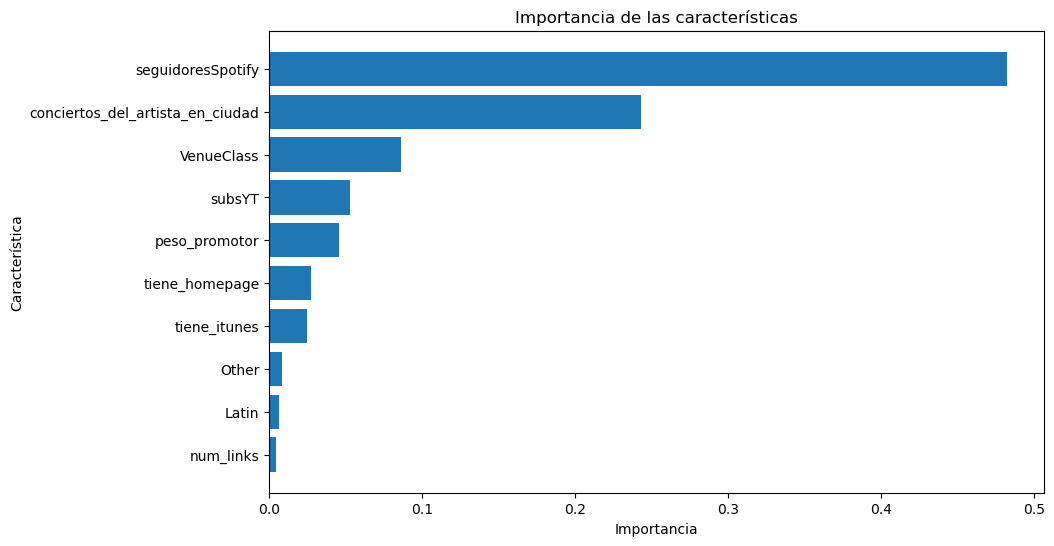

In [16]:
# Obtener variables importantes
feature_importance_grid = best_model_grid.feature_importances_

# Obtener los índices de las variables más importantes
top_indices_grid = np.argsort(feature_importance_grid)[::-1][:10]

print("\nLas 10 variables más importantes:")
for i in top_indices_grid:
    print(f"{X.columns[i]}: {feature_importance_grid[i]}")

# Crear un DataFrame para las importancias de las características
df_feature_importance = pd.DataFrame({
    'Característica': X.columns[top_indices_grid],
    'Importancia': feature_importance_grid[top_indices_grid]
})

# Visualizar las características más importantes
plt.figure(figsize=(10, 6))
plt.barh(df_feature_importance['Característica'], df_feature_importance['Importancia'])
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las características')
plt.gca().invert_yaxis()
plt.show()

MODELO BASE CON RANDOM FOREST

In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import PredefinedSplit, cross_validate
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, make_scorer
import numpy as np
import time

# Definir la semilla aleatoria
RANDOM_STATE = 83

# Definir el array test_fold a partir de la columna 'fold'
test_fold = datos['fold'].values

# Crear el PredefinedSplit
ps = PredefinedSplit(test_fold=test_fold)

# Definir las métricas a utilizar
scoring = {
    'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'rmse': make_scorer(mean_squared_error, squared=False),
    'mse': 'neg_mean_squared_error',
    'mae': make_scorer(mean_absolute_error, greater_is_better=False)
}

# Inicializar el modelo RandomForestRegressor
forest = RandomForestRegressor(random_state=RANDOM_STATE)

# Tiempo de inicio de la ejecución
start_time = time.time()

# Obtener los scores de validación cruzada para todas las métricas
scores = cross_validate(forest, X, y, cv=ps, scoring=scoring, return_train_score=True, return_estimator=True)

# Tiempo de finalización de la ejecución
end_time = time.time()

# Calcular el tiempo de ejecución en segundos
execution_time = end_time - start_time

# Imprimir el tiempo de ejecución
print("Tiempo de ejecución:", execution_time, "segundos")

# Crear la tabla de resultados
resultados = crear_tabla_resultados(scores)

run_name = "MODELO Base Random Forest"
mlp = forest  # Tu modelo

# Llamar a la función cargar_modelo_mlflow
cargar_modelo_mlflow(forest, experiment_name, run_name, resultados, execution_time)


Tiempo de ejecución: 0.5215511322021484 segundos


In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


print('MODELO RANDOM FOREST PARÁMETROS GRID SEARCH')

# Definir el modelo base
rf = RandomForestRegressor(random_state=RANDOM_STATE)
# Definir las métricas a utilizar
scoring = {
    'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False),
    'rmse': make_scorer(mean_squared_error, squared=False),
    'mse': 'neg_mean_squared_error',
    'mae': make_scorer(mean_absolute_error, greater_is_better=False)
}
params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 20, 25, 30, 45, 55],
    'min_samples_split': [2, 3, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 5, 8]
}

# Crear el generador de índices personalizado para usar con GridSearchCV
cv = PredefinedSplit(test_fold=datos['fold'])

start_time_grid = time.time()
gridSearch = GridSearchCV(estimator=rf, param_grid=params, cv=cv,
                          n_jobs=-1, scoring='neg_mean_squared_error')
gridSearch.fit(X, y)
end_time_grid = time.time()
execution_time_grid = end_time_grid - start_time_grid

print("Tiempo de ejecución GridSearchCV:", execution_time_grid, "segundos")
print('Mejores parámetros GridSearchCV: ', gridSearch.best_params_)
print('Mejor puntuación (MSE) GridSearchCV: ', -gridSearch.best_score_)

best_model_grid = gridSearch.best_estimator_

# Obtener variables importantes
feature_importance_grid = best_model_grid.feature_importances_

# Obtener los índices de las variables más importantes
top_indices_grid = np.argsort(feature_importance_grid)[::-1][:10]

print("\nLas 10 variables más importantes:")
for i in top_indices_grid:
    print(f"{X.columns[i]}: {feature_importance_grid[i]}")

# Realizar la validación cruzada con el mejor modelo
scores = cross_validate(best_model_grid, X, y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=True)

# Crear la tabla de resultados
resultados = crear_tabla_resultados(scores)

run_name = "MODELO GridSearchCV Random Forest"

# Llamar a la función cargar_modelo_mlflow
cargar_modelo_mlflow(best_model_grid, experiment_name, run_name, resultados, execution_time)



MODELO RANDOM FOREST PARÁMETROS GRID SEARCH
Tiempo de ejecución GridSearchCV: 59.45949697494507 segundos
Mejores parámetros GridSearchCV:  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Mejor puntuación (MSE) GridSearchCV:  199.38249518969985

Las 10 variables más importantes:
seguidoresSpotify: 0.3236947779350566
conciertos_del_artista_en_ciudad: 0.14558598112864155
popularidad: 0.13058862499773502
dias_Venta: 0.07704610587917099
peso_promotor: 0.06792681892511815
subsYT: 0.04392725556820235
num_links: 0.03520238195799884
NumGeneros: 0.03209943523382736
K-Pop: 0.03158288489853082
Pop: 0.018795996606001855


In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, make_scorer
import time
import numpy as np
import pandas as pd

# Definir la semilla aleatoria
RANDOM_STATE = 83

print('MODELO PARÁMETROS RANDOM FOREST RANDOM SEARCH')

# Definir el modelo base
rf = RandomForestRegressor(random_state=RANDOM_STATE)

params = {
    'n_estimators': [50, 120, 150, 250],
    'max_depth': [None, 20, 25, 35, 40, 50],
    'min_samples_split': [2, 3, 5, 10, 12, 17],
    'min_samples_leaf': [1, 2, 3, 5, 4]
}


# Crear el generador de índices personalizado para usar con RandomizedSearchCV
cv = PredefinedSplit(test_fold=datos['fold'])

# Realizar la búsqueda aleatoria de hiperparámetros
start_time_random = time.time()
randomSearch = RandomizedSearchCV(estimator=rf, param_distributions=params, n_iter=100, cv=cv,
                                  n_jobs=-1, scoring='neg_mean_squared_error', random_state=RANDOM_STATE)
randomSearch.fit(X, y)
end_time_random = time.time()
execution_time_random = end_time_random - start_time_random

print("Tiempo de ejecución RandomizedSearchCV:", execution_time_random, "segundos")
print('Mejores parámetros RandomizedSearchCV: ', randomSearch.best_params_)
print('Mejor puntuación (MSE) RandomizedSearchCV: ', -randomSearch.best_score_)

best_model_random = randomSearch.best_estimator_

# Obtener variables importantes
feature_importance_random = best_model_random.feature_importances_

# Obtener los índices de las variables más importantes
top_indices_random = np.argsort(feature_importance_random)[::-1][:10]

print("\nLas 10 variables más importantes:")
for i in top_indices_random:
    print(f"{X.columns[i]}: {feature_importance_random[i]}")

# Definir las métricas de evaluación para la validación cruzada
scoring = {
    'mse': 'neg_mean_squared_error',
    'rmse': make_scorer(mean_squared_error, squared=False),
    'mape': 'neg_mean_absolute_percentage_error'
}

# Realizar la validación cruzada con el mejor modelo de RandomizedSearchCV
scores = cross_validate(best_model_random, X, y, cv=cv, scoring=scoring, return_train_score=True, return_estimator=True)


# Crear la tabla de resultados
resultados = crear_tabla_resultados(scores)

run_name = "MODELO RandomizedSearchCV Random Forest"

# Llamar a la función cargar_modelo_mlflow
cargar_modelo_mlflow(best_model_random, experiment_name, run_name, resultados, execution_time)



MODELO PARÁMETROS RANDOM FOREST RANDOM SEARCH
Tiempo de ejecución RandomizedSearchCV: 11.002429962158203 segundos
Mejores parámetros RandomizedSearchCV:  {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 35}
Mejor puntuación (MSE) RandomizedSearchCV:  199.4016529897323

Las 10 variables más importantes:
seguidoresSpotify: 0.32369267625161985
conciertos_del_artista_en_ciudad: 0.14558597121968184
popularidad: 0.13059341042766984
dias_Venta: 0.07704619090725712
peso_promotor: 0.06745725394669289
subsYT: 0.04390767177393799
num_links: 0.03543891977538581
NumGeneros: 0.03210459884566011
K-Pop: 0.03158287812177501
Pop: 0.018795995409686413


ANÁLISIS POR SEGMENTOS POR VenueClass

In [34]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
import pandas as pd
import time

def calcular_metricas_cv(modelo, X, y, cv):
    mape_train_list = []
    rmse_train_list = []
    mse_train_list = []
    mape_val_list = []
    rmse_val_list = []
    mse_val_list = []

    start_time_cross_val = time.time()

    for i, (train_index, test_index) in enumerate(cv.split()):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        modelo.fit(X_train, y_train)

        predicciones_train = modelo.predict(X_train)
        predicciones_val = modelo.predict(X_val)

        # Calcular métricas de entrenamiento
        mape_train = mean_absolute_percentage_error(y_train, predicciones_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, predicciones_train))
        mse_train = mean_squared_error(y_train, predicciones_train)

        # Calcular métricas de validación
        mape_val = mean_absolute_percentage_error(y_val, predicciones_val)
        rmse_val = np.sqrt(mean_squared_error(y_val, predicciones_val))
        mse_val = mean_squared_error(y_val, predicciones_val)

        # Agregar métricas a las listas
        mape_train_list.append(mape_train)
        rmse_train_list.append(rmse_train)
        mse_train_list.append(mse_train)

        mape_val_list.append(mape_val)
        rmse_val_list.append(rmse_val)
        mse_val_list.append(mse_val)

    end_time_cross_val = time.time()
    execution_time_cross_val = end_time_cross_val - start_time_cross_val

    # Crear un DataFrame para las métricas de entrenamiento y validación
    df_metrics = pd.DataFrame({
        'Fold': [f'Fold {i+1}' for i in range(len(mape_train_list))],
        'MAPE Train': mape_train_list,
        'RMSE Train': rmse_train_list,
        'MSE Train': mse_train_list,
        'MAPE Val': mape_val_list,
        'RMSE Val': rmse_val_list,
        'MSE Val': mse_val_list
    })

    return df_metrics, execution_time_cross_val


In [38]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Inicializar el modelo RandomForestRegressor sin especificar hiperparámetros
best_model = RandomForestRegressor(n_estimators=50, min_samples_split= 5, min_samples_leaf= 2, max_depth=35,random_state=RANDOM_STATE)

# Entrenar el modelo
best_model.fit(X, y)

# Generar predicciones
y_pred = best_model.predict(X)

# Añadir las predicciones al DataFrame original
datos['pred'] = y_pred

# Crear una lista para almacenar los resultados
resultados_list = []

# Calcular las métricas para cada valor de "VenueClass"
for vc in datos['VenueClass'].unique():
    subset = datos[datos['VenueClass'] == vc]
    mse = mean_squared_error(subset['min_price'], subset['pred'])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(subset['min_price'], subset['pred'])
    resultados_list.append({'VenueClass': vc, 'mse': mse, 'rmse': rmse, 'mape': mape})

# Convertir la lista de resultados en un DataFrame
resultados = pd.DataFrame(resultados_list)

# Imprimir los resultados
print("\nResultados por 'VenueClass':")
resultados



Resultados por 'VenueClass':


,VenueClass,mse,rmse,mape
0,2,46.733254,6.836172,0.087456
1,3,72.829487,8.534019,0.144593
2,1,40.462450,6.361010,0.084967
3,0,48.197645,6.942452,0.085381


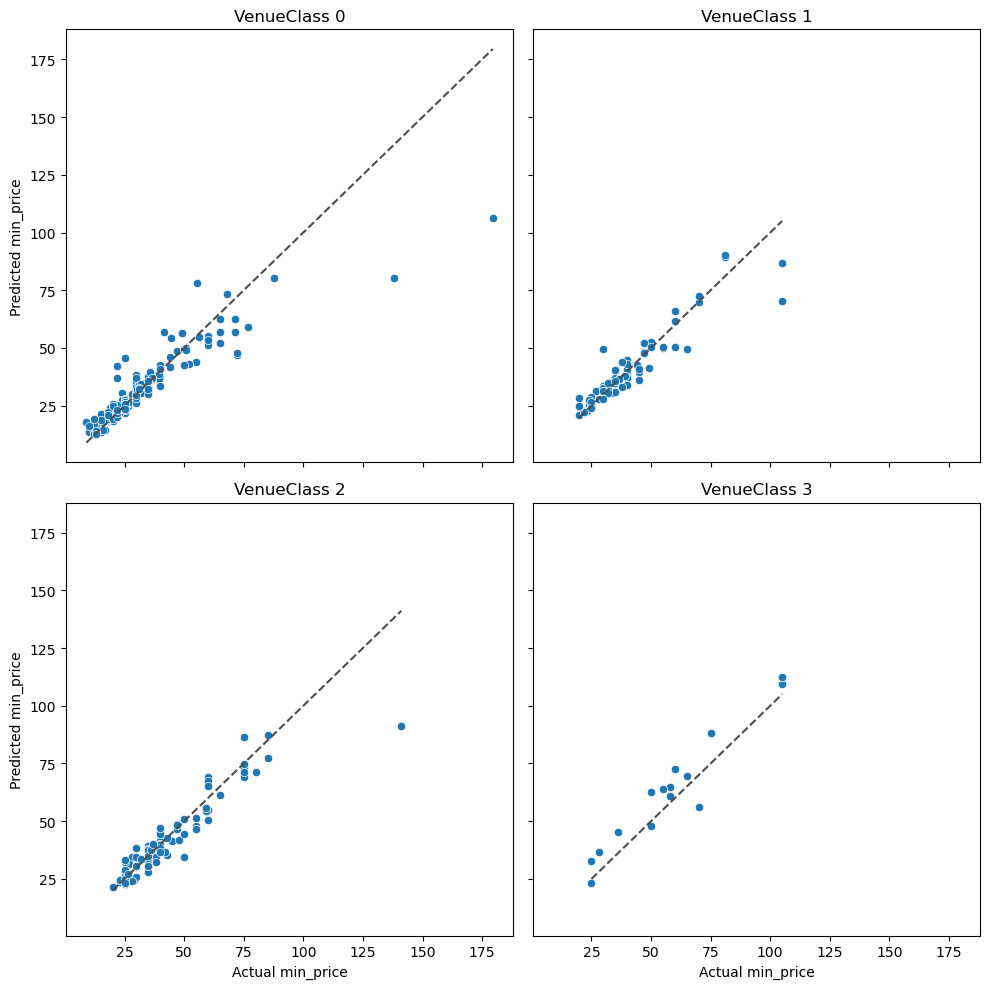

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear gráficos de dispersión para comparar predicciones con valores reales por cada "VenueClass"
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

# Asegurarnos de que los valores de 'VenueClass' están ordenados para una mejor visualización
venue_classes = sorted(datos['VenueClass'].unique())

for idx, vc in enumerate(venue_classes):
    subset = datos[datos['VenueClass'] == vc]
    ax = axes[idx//2, idx%2]  # Ubicación del gráfico en la cuadrícula
    sns.scatterplot(ax=ax, x=subset['min_price'], y=subset['pred'])
    ax.plot([subset['min_price'].min(), subset['min_price'].max()],
            [subset['min_price'].min(), subset['min_price'].max()],
            ls="--", c=".3")
    ax.set_title(f'VenueClass {vc}')
    ax.set_xlabel('Actual min_price')
    ax.set_ylabel('Predicted min_price')

plt.tight_layout()
plt.show()

In [40]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px

# Define el modelo con los parámetros encontrados mediante RandomizedSearchCV
best_model_random = RandomForestRegressor(n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_depth=35, random_state=RANDOM_STATE)

# Entrena el modelo con tus datos
best_model_random.fit(X, y)

# Realiza predicciones con el modelo entrenado
predicciones = best_model_random.predict(X)

# Crea un DataFrame con los precios reales, predichos y el nombre del concierto
df = pd.DataFrame({'Nombre del Concierto': datos1['name'], 'Precio Real': y, 'Precio Predicho': predicciones})

# Crea un scatter plot interactivo con Plotly
fig = px.scatter(df, x='Precio Real', y='Precio Predicho', color='Nombre del Concierto',
                 title='Comparación de Precios Reales vs Precios Predichos (Random Forest)',
                 labels={'Precio Real': 'Precio Real', 'Precio Predicho': 'Precio Predicho'})

# Agrega una línea diagonal que representa la igualdad entre los precios reales y predichos
fig.add_shape(type='line',
              x0=df['Precio Real'].min(), y0=df['Precio Real'].min(),
              x1=df['Precio Real'].max(), y1=df['Precio Real'].max(),
              line=dict(color='red', width=2, dash='dash'))

# Mostrar el scatter plot interactivo
fig.show()
